# Plotting epi parameter estimates from bayesian logistic growth model 

### setup

In [122]:
library(ggplot2)
library(tidyverse)
library(RColorBrewer)
library(magrittr)
library(lubridate)

In [123]:
my_theme <- function() {
    theme_bw() +
    theme( 
        plot.title = element_text(color="black", size=12, face="bold"),
        axis.title.x = element_text(color="black", size=12, face="bold"),
        axis.title.y = element_text(color="black", size=12, face="bold"),
        axis.text.x = element_text(size= 10, vjust=0.5),
        axis.text.y = element_text(size = 10)
        )
}

## posterior distribution of netau under logistic growth model 

### Read in TSV 

In [124]:
path <- '/Users/nashwa/Desktop/git/hmpxv_dynamics/out/logistic/'
netau <- read.table(paste0(path,'logistic_growth_t50.tsv'), sep='\t', header=T)
head(netau)

,time,date,datetime,milliseconds,mean,median,upper,lower
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022.797,2022-10-18,2022-10-18T08:00:00,1.666080e+12,25.31316,20.31142,49.88838,11.43242
2,2022.790,2022-10-15,2022-10-15T18:05:03,1.665857e+12,24.82678,20.29794,49.80448,11.43185
3,2022.783,2022-10-13,2022-10-13T04:10:06,1.665634e+12,24.45672,20.27839,49.49118,11.43120
4,2022.776,2022-10-10,2022-10-10T14:15:09,1.665411e+12,24.15676,20.24913,49.10957,11.43046
5,2022.769,2022-10-08,2022-10-08T00:20:12,1.665188e+12,23.90278,20.22491,48.70991,11.42962
6,2022.762,2022-10-05,2022-10-05T10:25:15,1.664966e+12,23.68077,20.21632,48.39194,11.42868


In [125]:
# format date 
netau <- netau %>% mutate(month = months(as.Date(datetime)))

In [180]:

time_interval <- ( max(netau$time) - min(netau$time) ) / 7

times <- 1:7
for (i in times) { 
    times[i] = i*time_interval + min(netau$time)
}

date_decimal(times)

[1] "2022-03-14 01:59:50 UTC" "2022-04-19 13:39:52 UTC"
[3] "2022-05-26 01:19:53 UTC" "2022-07-01 12:59:55 UTC"
[5] "2022-08-07 00:39:56 UTC" "2022-09-12 12:19:58 UTC"
[7] "2022-10-19 00:00:00 UTC"

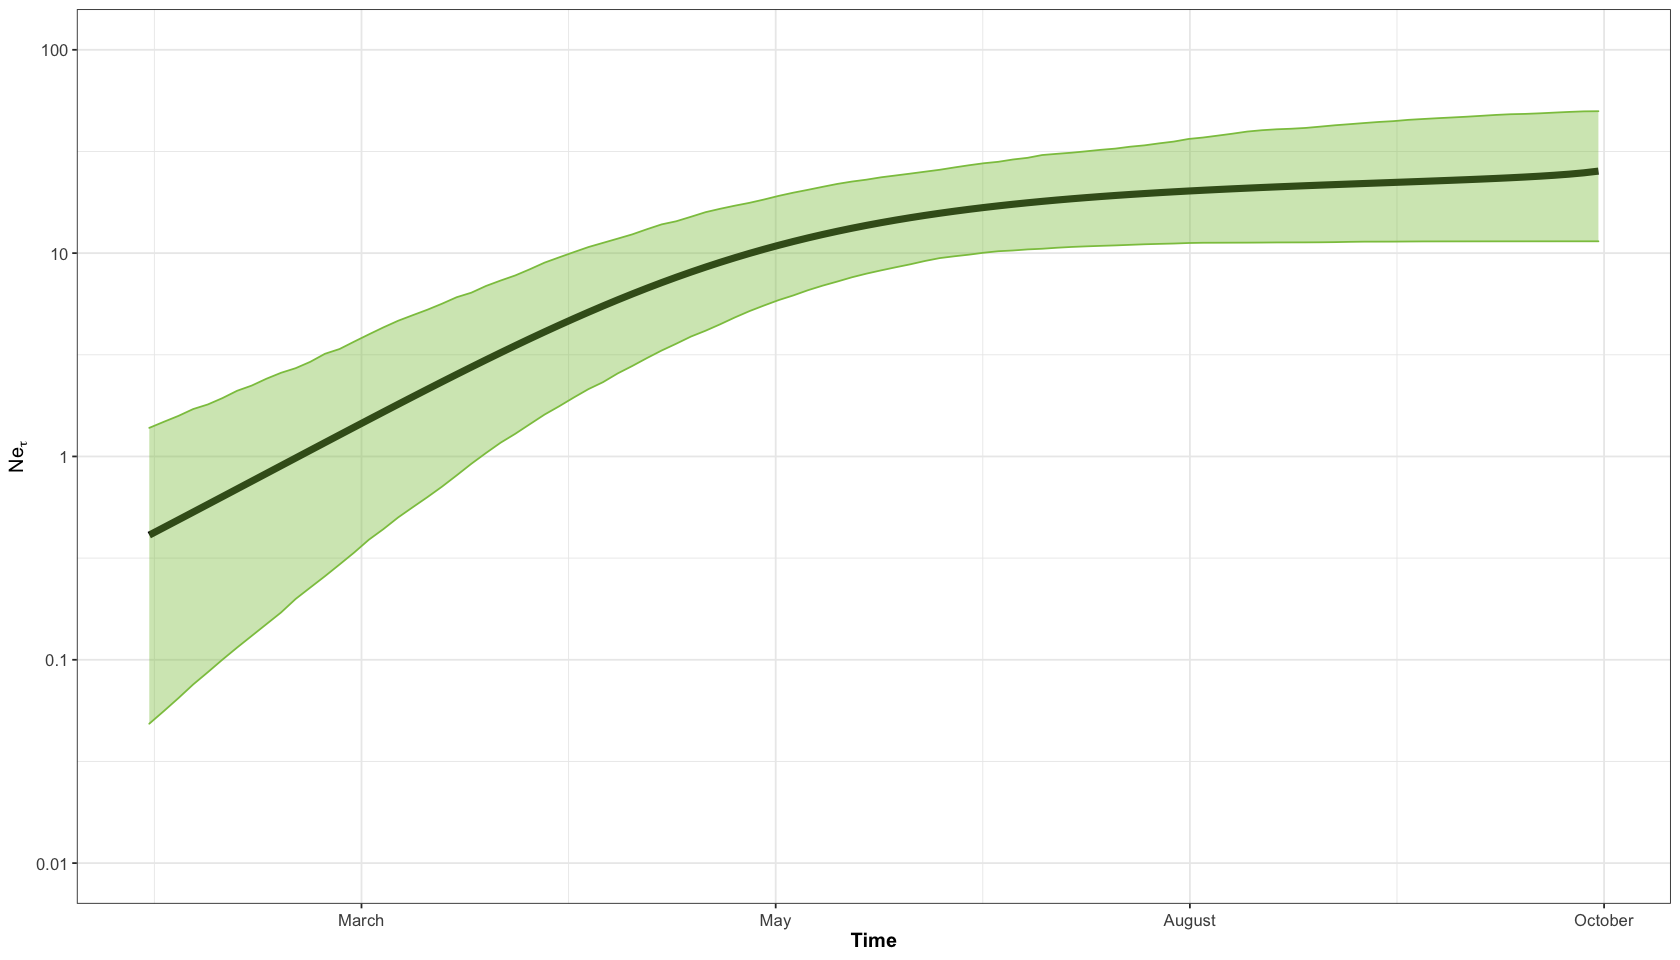

In [182]:
netau %>% ggplot(aes(x=time, y=mean)) + 
         geom_line(size=2, color='black') +
         geom_ribbon(aes(ymin=lower, ymax=upper), color=rgb(0.55,0.77,0.3), alpha=0.4, fill=rgb(0.55,0.77,0.3)) +
         ylab(bquote(Ne[tau])) + xlab('Time') + 
         scale_y_continuous(trans='log10', breaks=c(.01, .1, 1, 10, 100), limits=c(.01,100), labels=c( .01, .1, 1, 10, 100)) +
         scale_x_continuous(breaks=c(2022.2, 2022.4, 2022.6, 2022.8), labels=c('March','May','August','October')) +
         my_theme()

### Derive Ne from Netau

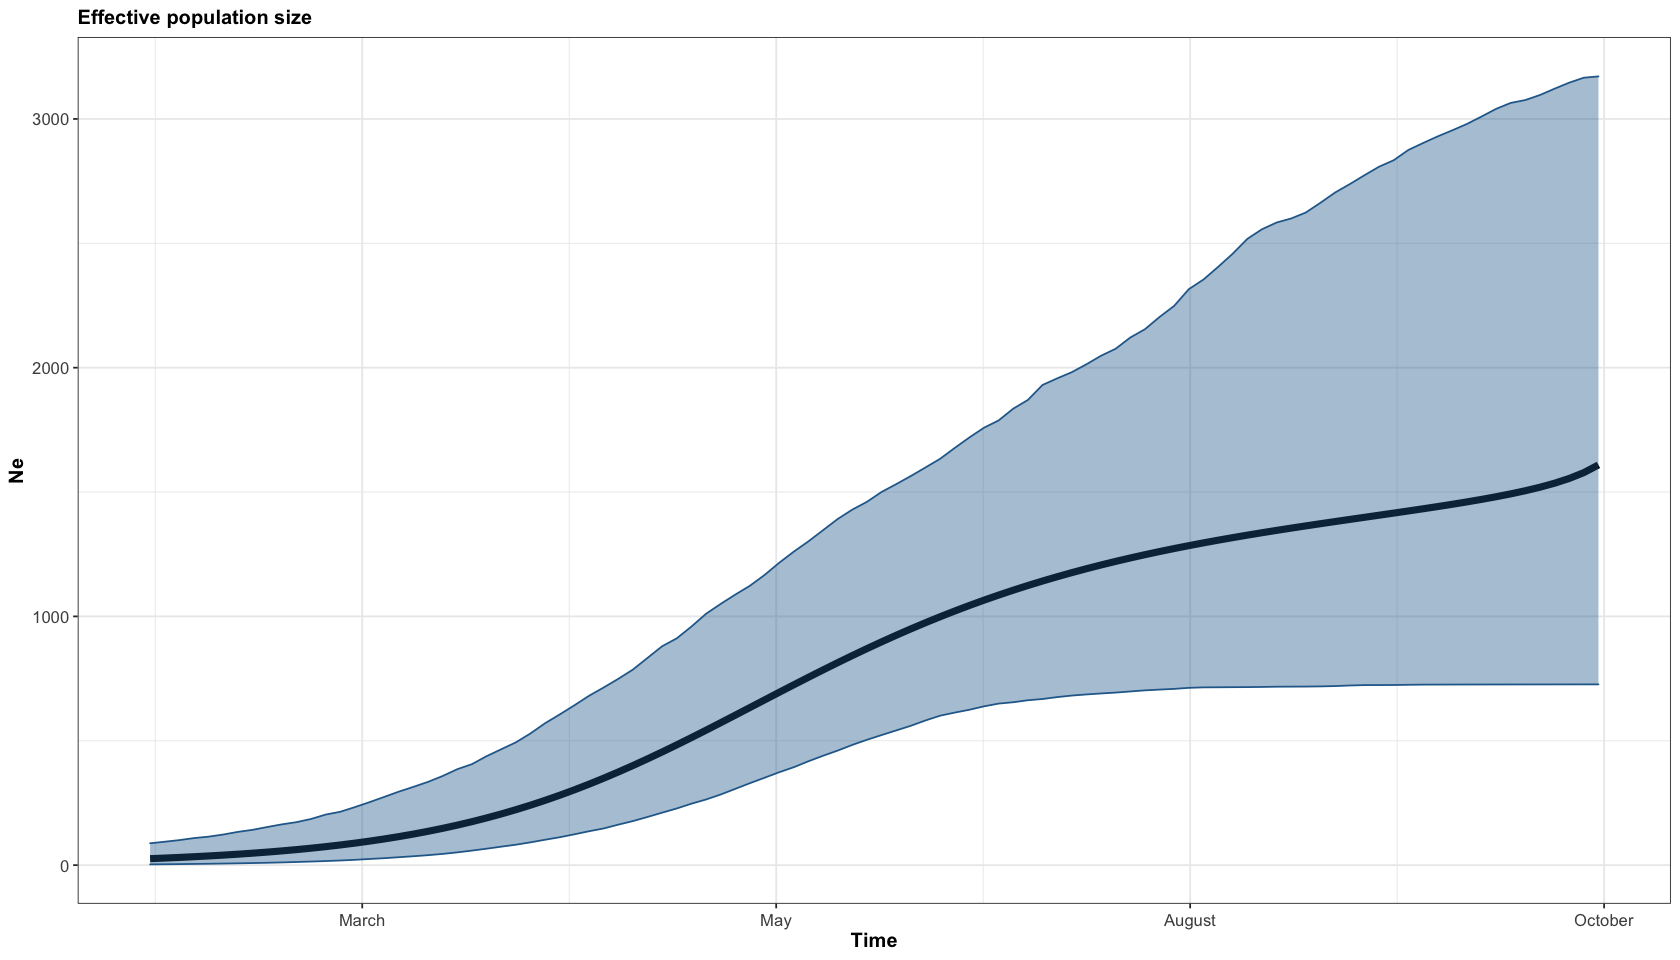

In [138]:
r_mean = 14.4011/365 #r per day
gamma <- 1/21 # recovery rate per day where infection length is 21 days 
beta <- r_mean + gamma #contact rate
tau_early <- (1/(2*beta)) / 365 #tau in years 

options(repr.plot.width=14, repr.plot.height=8)

netau %>% mutate(ne = mean/tau_early, 
                 ne_lower = lower/tau_early,
                 ne_upper = upper/tau_early) %>% 
          ggplot(aes(x=time, y=ne)) +
          geom_line(size=2, color='black') +
          geom_ribbon(aes(ymin=ne_lower, ymax=ne_upper), color=rgb(0.15,0.41,0.6), alpha=0.4, fill=rgb(0.15,0.41,0.6)) +
          ylab('Ne') + xlab('Time') + ggtitle('Effective population size') + 
          scale_x_continuous(breaks=c(2022.2, 2022.4, 2022.6, 2022.8), labels=c('March','May','August','October')) +
          my_theme()

Warning message:
“Removed 34 row(s) containing missing values (geom_path).”


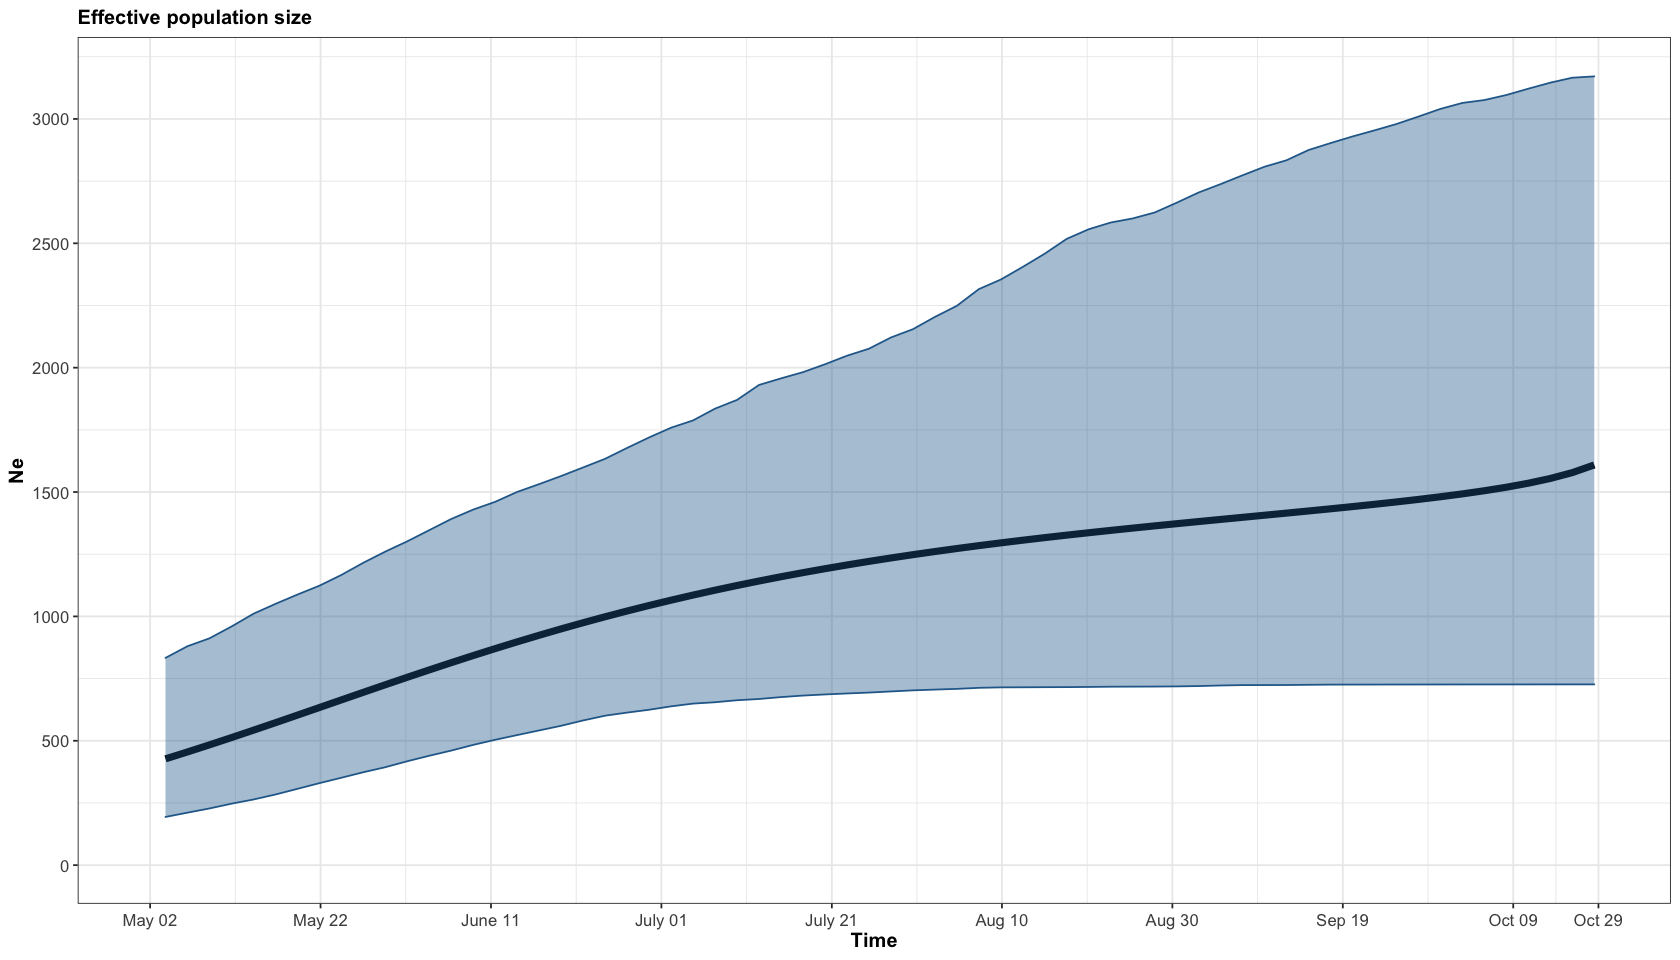

In [185]:
## do may 02 - oct 29

netau %>% mutate(ne = mean/tau_early, 
                 ne_lower = lower/tau_early,
                 ne_upper = upper/tau_early) %>% 
          ggplot(aes(x=time, y=ne)) +
          geom_line(size=2, color='black') +
          geom_ribbon(aes(ymin=ne_lower, ymax=ne_upper), color=rgb(0.15,0.41,0.6), alpha=0.4, fill=rgb(0.15,0.41,0.6)) +
          ylab('Ne') + xlab('Time') + ggtitle('Effective population size') + #xlim(c(2022.4, 2022.8)) +
          scale_x_continuous(limits=c(2022.3329,2022.7986), 
                             breaks=c(2022.3329, 2022.3877, 2022.4425, 2022.4973,
                                     2022.5521, 2022.6068, 2022.6616,2022.7164, 2022.7712, 2022.7986), 
                             labels=c('May 02','May 22','June 11','July 01', 'July 21',
                                      'Aug 10', 'Aug 30', 'Sep 19', 'Oct 09', 'Oct 29')) +
          scale_y_continuous(breaks=c(0, 500, 1000, 1500, 2000, 2500, 3000)) +
          my_theme()

### Plot exponential growth rate 

In [119]:
# parameter estimates via tracer
#k <- 25.3132
#r <- 0.039 # in years
#taut <- 0.016 # in yers 